# COVID-19 数据分析：健康与社会经济影响

本 notebook 将分析 COVID-19 的健康和社会经济影响，主要研究以下问题：
1. COVID-19 如何影响不同地区的预期寿命
2. 健康影响（病例数、死亡数）与经济影响（GDP 下降、失业率）的对比
3. 低收入国家是否比富裕国家受到更不成比例的影响

## 1. 数据准备与导入

In [1]:
# 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
import statsmodels.api as sm
from scipy import stats

# 导入自定义工具函数
from covid_analysis_utils import *

# 设置中文字体
setup_chinese_fonts()

# 设置绘图风格
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [2]:
# 加载并预处理数据
df = load_and_preprocess_data()
print(f"数据集大小: {df.shape}")
df.head()

数据集大小: (429435, 72)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,year,month,day,week,quarter
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,5,1,1
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,6,2,1
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,7,2,1
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,8,2,1
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,9,2,1


## 2. 数据清洗与准备

In [3]:
# 数据清洗
df_clean = clean_data(df)

原始数据形状: (429435, 72)
缺失值比例:
weekly_icu_admissions                      97.440125
weekly_icu_admissions_per_million          97.440125
excess_mortality_cumulative_per_million    96.877059
excess_mortality_cumulative_absolute       96.877059
excess_mortality_cumulative                96.877059
                                             ...    
new_deaths_per_million                      4.384133
total_deaths                                4.105627
total_cases                                 4.105627
total_deaths_per_million                    4.105627
total_cases_per_million                     4.105627
Length: 63, dtype: float64

清洗后数据形状: (429435, 72)


In [4]:
# 查看与社会经济相关的列
socio_columns = ['gdp_per_capita', 'extreme_poverty', 'life_expectancy', 'human_development_index']
print("社会经济相关列:")
for col in socio_columns:
    print(f"- {col}")

# 检查数据的可用性
print("\n数据可用性（非空值百分比）:")
for col in socio_columns:
    non_null_pct = (df_clean[col].notnull().sum() / len(df_clean)) * 100
    print(f"- {col}: {non_null_pct:.2f}%")

社会经济相关列:
- gdp_per_capita
- extreme_poverty
- life_expectancy
- human_development_index

数据可用性（非空值百分比）:
- gdp_per_capita: 76.45%
- extreme_poverty: 49.37%
- life_expectancy: 90.89%
- human_development_index: 74.31%


In [5]:
# 筛选有足够社会经济数据的国家
# 我们主要关注有GDP数据和生命预期数据的国家
country_socio_data = df_clean.groupby('location').agg({
    'gdp_per_capita': 'count',
    'life_expectancy': 'count'
}).reset_index()

# 筛选同时有GDP和生命预期数据的国家
countries_with_socio_data = country_socio_data[
    (country_socio_data['gdp_per_capita'] > 0) & 
    (country_socio_data['life_expectancy'] > 0)
]['location'].tolist()

print(f"有社会经济数据的国家数量: {len(countries_with_socio_data)}")

# 筛选这些国家的数据
socio_df = df_clean[df_clean['location'].isin(countries_with_socio_data)].copy()
print(f"筛选后的数据大小: {socio_df.shape}")

有社会经济数据的国家数量: 195
筛选后的数据大小: (326618, 72)


## 3. COVID-19 对预期寿命的影响

In [6]:
# 分析COVID-19死亡率与预期寿命的关系

# 计算每个国家的累计死亡率（每百万人口）
country_mortality = socio_df.groupby('location').agg({
    'total_deaths_per_million': 'max',  # 使用最大值（最新累计值）
    'life_expectancy': 'first',  # 使用第一个值（基本不变）
    'continent': 'first',  # 记录大洲
    'gdp_per_capita': 'first'  # 记录人均GDP
}).reset_index()

# 删除死亡率为NaN的行
country_mortality = country_mortality.dropna(subset=['total_deaths_per_million', 'life_expectancy'])

# 按大洲分组，查看不同地区的情况
continent_mortality = country_mortality.groupby('continent').agg({
    'total_deaths_per_million': 'mean',
    'life_expectancy': 'mean',
    'location': 'count'  # 计算每个大洲的国家数量
}).reset_index()
continent_mortality.columns = ['continent', 'avg_deaths_per_million', 'avg_life_expectancy', 'country_count']

# 排序
continent_mortality = continent_mortality.sort_values('avg_deaths_per_million', ascending=False)

print("各大洲的COVID-19死亡率与平均预期寿命:")
print(continent_mortality)

各大洲的COVID-19死亡率与平均预期寿命:
       continent  avg_deaths_per_million  avg_life_expectancy  country_count
2         Europe             2935.432195            79.495366             41
5  South America             2667.030000            75.090833             12
3  North America             1624.639630            76.204444             27
1           Asia              697.486889            74.138222             45
4        Oceania              379.885000            71.182143             14
0         Africa              304.989057            64.240566             53


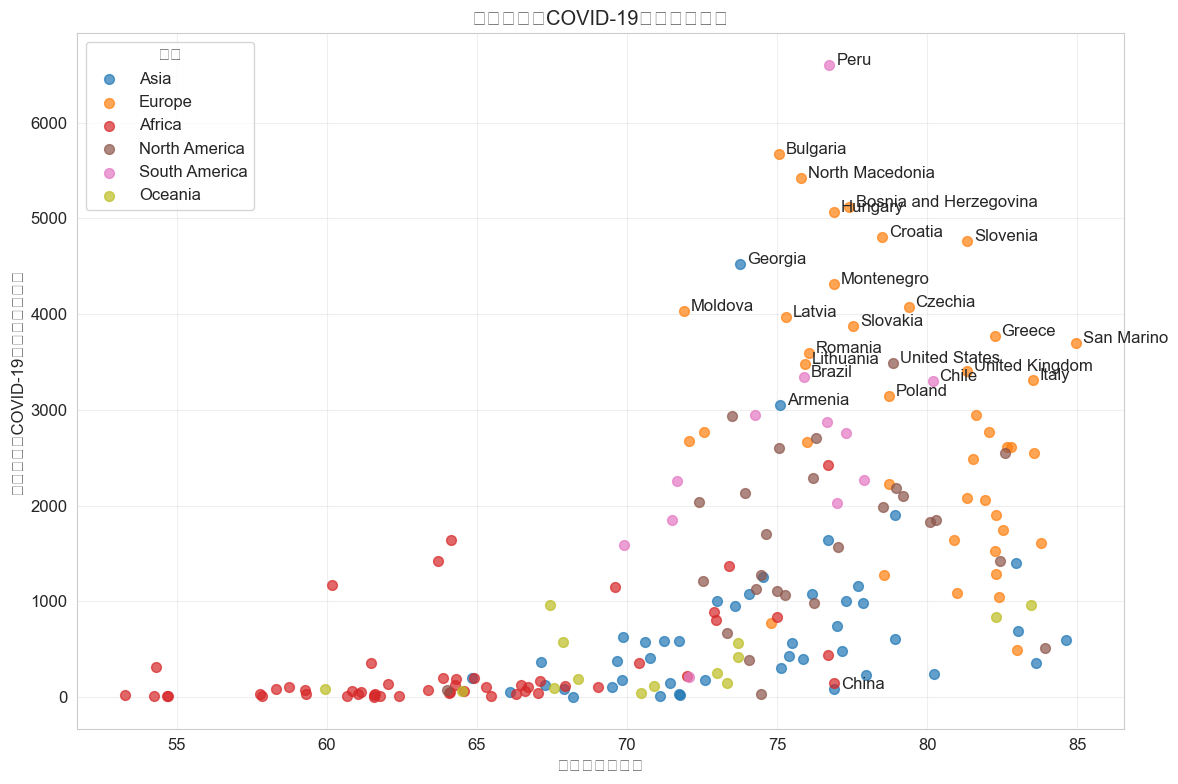

In [7]:
# 绘制散点图：预期寿命 vs COVID-19死亡率
plt.figure(figsize=(12, 8))

# 按大洲设置不同颜色
continents = country_mortality['continent'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(continents)))
continent_color_map = dict(zip(continents, colors))

# 绘制散点图
for continent in continents:
    if pd.isna(continent):
        continue
    continent_data = country_mortality[country_mortality['continent'] == continent]
    plt.scatter(continent_data['life_expectancy'], 
                continent_data['total_deaths_per_million'],
                label=continent, color=continent_color_map[continent],
                alpha=0.7, s=50)

# 标注部分国家
for i, row in country_mortality.iterrows():
    if row['total_deaths_per_million'] > 3000 or row['total_deaths_per_million'] < 100 and row['life_expectancy'] > 75:
        plt.annotate(row['location'], 
                     xy=(row['life_expectancy'], row['total_deaths_per_million']),
                     xytext=(5, 0), textcoords='offset points')

plt.xlabel('预期寿命（年）')
plt.ylabel('每百万人口COVID-19死亡数（累计）')
plt.title('预期寿命与COVID-19死亡率的关系')
plt.legend(title='大洲')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [8]:
# 计算预期寿命与死亡率的相关性
corr, p_value = stats.pearsonr(country_mortality['life_expectancy'], country_mortality['total_deaths_per_million'])
print(f"预期寿命与COVID-19死亡率的相关系数: {corr:.3f} (p={p_value:.3f})")

# 进行简单线性回归
X = sm.add_constant(country_mortality['life_expectancy'])
model = sm.OLS(country_mortality['total_deaths_per_million'], X).fit()
print(model.summary())

预期寿命与COVID-19死亡率的相关系数: 0.535 (p=0.000)
                               OLS Regression Results                               
Dep. Variable:     total_deaths_per_million   R-squared:                       0.286
Model:                                  OLS   Adj. R-squared:                  0.282
Method:                       Least Squares   F-statistic:                     76.41
Date:                      Thu, 20 Mar 2025   Prob (F-statistic):           1.18e-15
Time:                              14:29:07   Log-Likelihood:                -1639.5
No. Observations:                       193   AIC:                             3283.
Df Residuals:                           191   BIC:                             3289.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [9]:
# 估算COVID-19造成的预期寿命损失
# 根据WHO的数据，COVID-19造成的年龄调整死亡率可以用来估算预期寿命的变化
# 这里我们使用一个简化的方法：假设每1000例/百万人口的死亡率导致约0.1年的预期寿命下降

country_mortality['estimated_life_expectancy_loss'] = country_mortality['total_deaths_per_million'] / 1000 * 0.1

# 查看预期寿命损失最大的10个国家
top_life_expectancy_loss = country_mortality.sort_values('estimated_life_expectancy_loss', ascending=False).head(10)
print("预期寿命损失估计最大的10个国家:")
print(top_life_expectancy_loss[['location', 'total_deaths_per_million', 'estimated_life_expectancy_loss', 'life_expectancy']])

# 按大洲分组
continent_life_loss = country_mortality.groupby('continent').agg({
    'estimated_life_expectancy_loss': 'mean'
}).reset_index()

print("\n各大洲的平均预期寿命损失估计:")
print(continent_life_loss.sort_values('estimated_life_expectancy_loss', ascending=False))

预期寿命损失估计最大的10个国家:
                   location  total_deaths_per_million  \
137                    Peru                   6601.11   
26                 Bulgaria                   5669.61   
128         North Macedonia                   5422.13   
22   Bosnia and Herzegovina                   5114.82   
77                  Hungary                   5065.21   
43                  Croatia                   4799.55   
160                Slovenia                   4766.86   
65                  Georgia                   4519.36   
116              Montenegro                   4317.90   
45                  Czechia                   4076.47   

     estimated_life_expectancy_loss  life_expectancy  
137                        0.660111            76.74  
26                         0.566961            75.05  
128                        0.542213            75.80  
22                         0.511482            77.40  
77                         0.506521            76.88  
43                      

## 4. 健康影响与经济影响的对比

In [10]:
# 由于我们没有GDP下降的直接数据，我们将使用严格度指数作为经济影响的代理指标
# 一般来说，严格的限制措施会导致短期内较大的经济损失

# 计算每个国家的平均严格度指数和死亡率
country_impact = socio_df.groupby('location').agg({
    'stringency_index': 'mean',
    'total_deaths_per_million': 'max',
    'gdp_per_capita': 'first',
    'continent': 'first'
}).reset_index()

# 删除有缺失值的行
country_impact = country_impact.dropna(subset=['stringency_index', 'total_deaths_per_million', 'gdp_per_capita'])

# 将国家按GDP分成高中低三组
country_impact['gdp_group'] = pd.qcut(country_impact['gdp_per_capita'], 3, labels=['低收入', '中等收入', '高收入'])

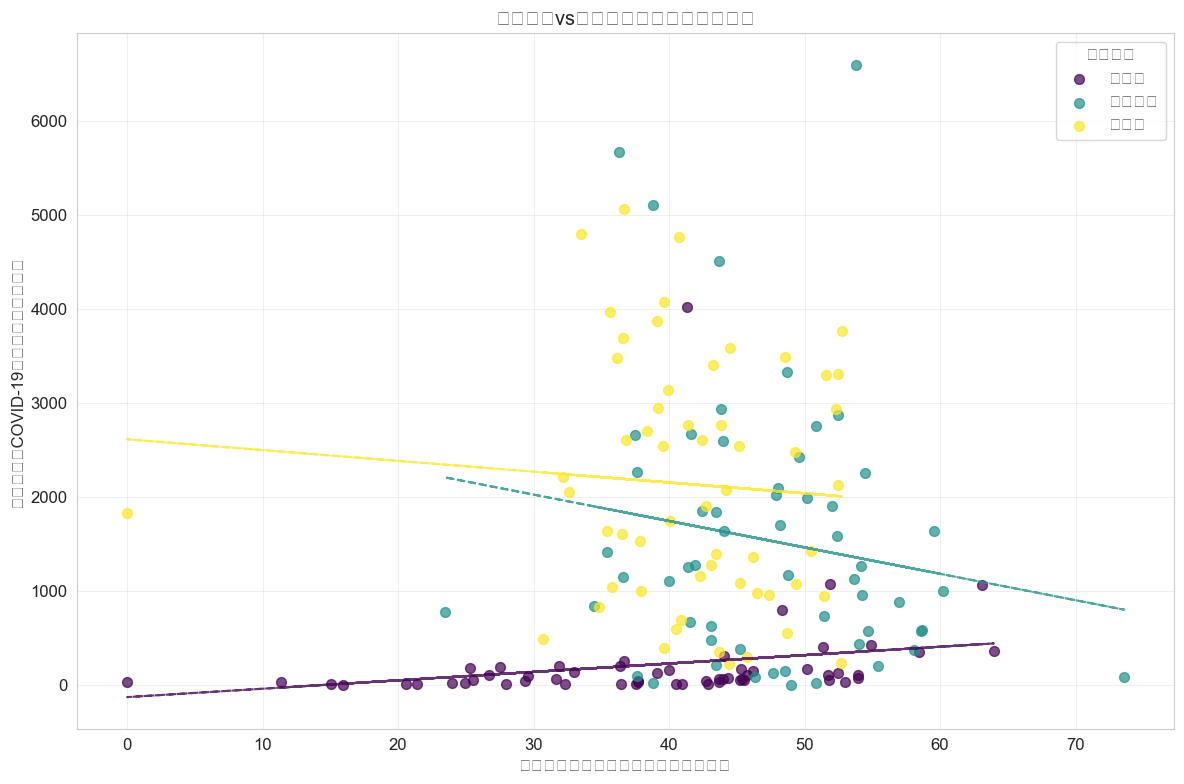

In [11]:
# 绘制散点图：严格度指数 vs 死亡率，按GDP分组着色
plt.figure(figsize=(12, 8))

# 按GDP分组设置不同颜色
gdp_groups = country_impact['gdp_group'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(gdp_groups)))
gdp_color_map = dict(zip(gdp_groups, colors))

# 绘制散点图
for gdp_group in gdp_groups:
    group_data = country_impact[country_impact['gdp_group'] == gdp_group]
    plt.scatter(group_data['stringency_index'], 
                group_data['total_deaths_per_million'],
                label=gdp_group, color=gdp_color_map[gdp_group],
                alpha=0.7, s=50)

# 为每个GDP组添加趋势线
for gdp_group in gdp_groups:
    group_data = country_impact[country_impact['gdp_group'] == gdp_group]
    if len(group_data) > 2:
        x = group_data['stringency_index']
        y = group_data['total_deaths_per_million']
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x), color=gdp_color_map[gdp_group], linestyle='--', alpha=0.8)

plt.xlabel('平均严格度指数（经济影响代理指标）')
plt.ylabel('每百万人口COVID-19死亡数（健康影响）')
plt.title('健康影响vs经济影响：按收入水平分组')
plt.legend(title='收入组别')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [12]:
# 按GDP组和大洲分析严格度指数与死亡率的关系
# 按GDP组计算平均值
gdp_group_impact = country_impact.groupby('gdp_group').agg({
    'stringency_index': 'mean',
    'total_deaths_per_million': 'mean',
    'gdp_per_capita': 'mean',
    'location': 'count'
}).reset_index()

print("按收入水平分组的健康和经济影响:")
print(gdp_group_impact)

# 按大洲计算平均值
continent_impact = country_impact.groupby('continent').agg({
    'stringency_index': 'mean',
    'total_deaths_per_million': 'mean',
    'gdp_per_capita': 'mean',
    'location': 'count'
}).reset_index()

print("\n按大洲分组的健康和经济影响:")
print(continent_impact)

按收入水平分组的健康和经济影响:
  gdp_group  stringency_index  total_deaths_per_million  gdp_per_capita  \
0       低收入         38.877960                221.332807     2878.956140   
1      中等收入         47.408239               1539.777544    12454.799649   
2       高收入         41.654488               2138.506140    42161.586842   

   location  
0        57  
1        57  
2        57  

按大洲分组的健康和经济影响:
       continent  stringency_index  total_deaths_per_million  gdp_per_capita  \
0         Africa         39.223212                314.971429     5304.147755   
1           Asia         47.561800                645.054651    22524.971628   
2         Europe         39.646662               2836.222821    34918.708205   
3  North America         43.450308               1653.313000    20752.157500   
4        Oceania         39.858676                427.985000    13224.412500   
5  South America         49.285750               2667.030000    13840.786667   

   location  
0        49  
1        43  
2      

In [13]:
# 比较不同GDP组的严格度-死亡率效率
# 计算每个国家的效率比率：死亡率/严格度指数
# 比率越低，表示单位严格度带来的死亡率越低，即政策效率越高
country_impact['efficiency_ratio'] = country_impact['total_deaths_per_million'] / country_impact['stringency_index']

# 按GDP组计算平均效率比率
gdp_efficiency = country_impact.groupby('gdp_group').agg({
    'efficiency_ratio': ['mean', 'median', 'std'],
    'location': 'count'
}).reset_index()

print("按收入水平分组的政策效率:")
print(gdp_efficiency)

按收入水平分组的政策效率:
  gdp_group efficiency_ratio                      location
                        mean     median       std    count
0       低收入              inf   2.026736       NaN       57
1      中等收入        34.220407  27.682974  33.17612       57
2       高收入              inf  47.076649       NaN       57


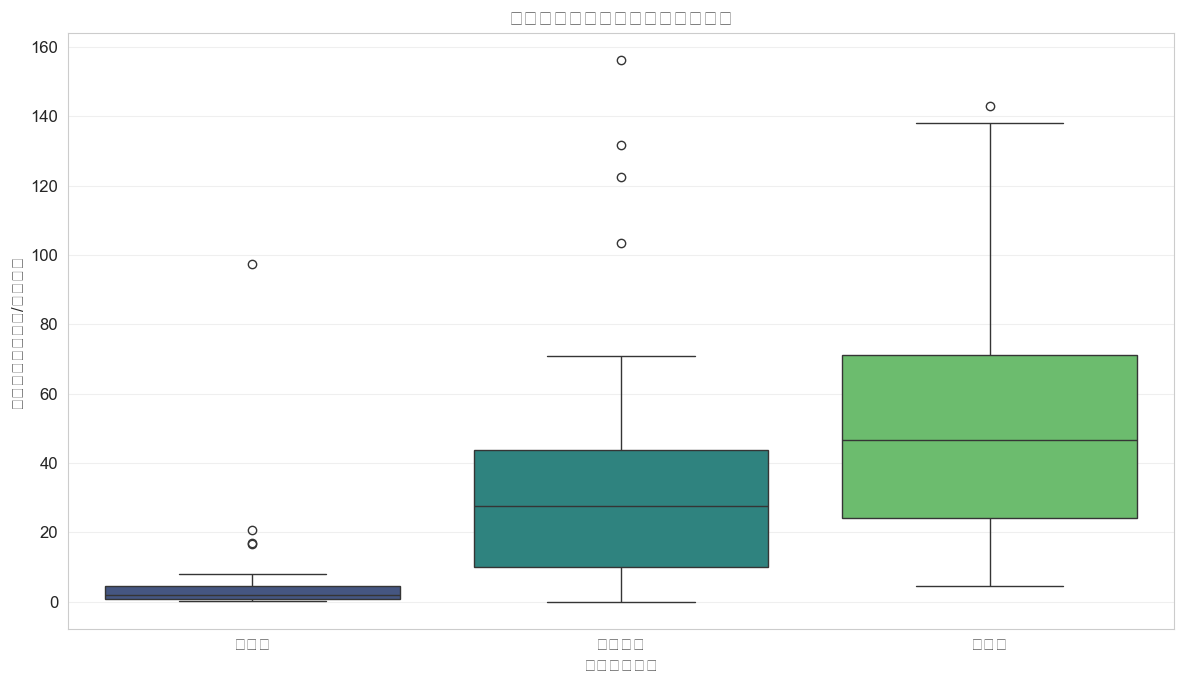

In [14]:
# 绘制箱线图：不同GDP组的效率比率
plt.figure(figsize=(12, 7))
sns.boxplot(x='gdp_group', y='efficiency_ratio', data=country_impact, palette='viridis')
plt.xlabel('收入水平组别')
plt.ylabel('效率比率（死亡率/严格度）')
plt.title('不同收入水平国家的政策效率对比')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

## 5. 低收入国家的不成比例影响

In [15]:
# 分析极端贫困与COVID-19影响的关系
# 查看极端贫困数据的可用性
poverty_data_count = socio_df['extreme_poverty'].notnull().sum()
print(f"极端贫困数据可用性: {poverty_data_count} 行 ({poverty_data_count/len(socio_df)*100:.2f}%)")

# 计算每个国家的极端贫困率和COVID-19影响
country_poverty = socio_df.groupby('location').agg({
    'extreme_poverty': 'first',
    'total_deaths_per_million': 'max',
    'gdp_per_capita': 'first',
    'continent': 'first',
    'stringency_index': 'mean'
}).reset_index()

# 删除极端贫困率为NaN的行
country_poverty = country_poverty.dropna(subset=['extreme_poverty', 'total_deaths_per_million'])
print(f"有极端贫困数据的国家数量: {len(country_poverty)}")

极端贫困数据可用性: 210322 行 (64.39%)
有极端贫困数据的国家数量: 125


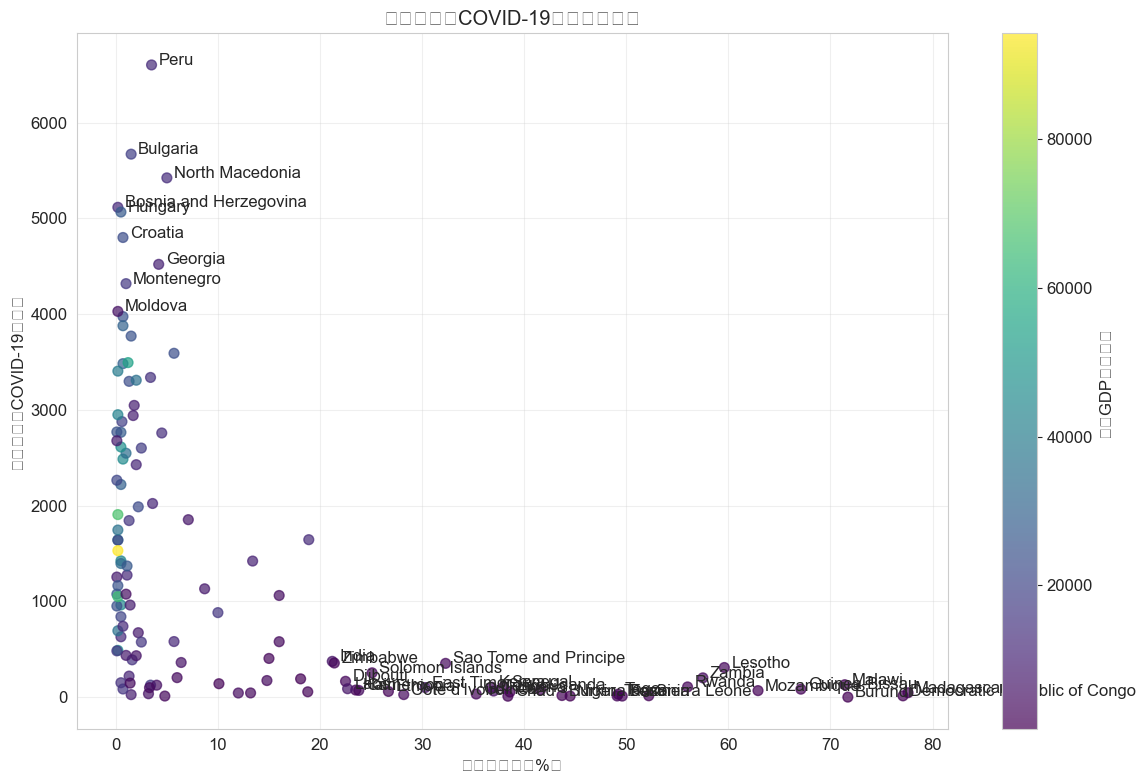

In [16]:
# 绘制散点图：极端贫困率 vs COVID-19死亡率
plt.figure(figsize=(12, 8))

# 绘制散点图
plt.scatter(country_poverty['extreme_poverty'], 
            country_poverty['total_deaths_per_million'],
            alpha=0.7, s=50, c=country_poverty['gdp_per_capita'], cmap='viridis')

# 添加颜色条
plt.colorbar(label='人均GDP（美元）')

# 标注部分国家
for i, row in country_poverty.iterrows():
    if row['extreme_poverty'] > 20 or row['total_deaths_per_million'] > 4000:
        plt.annotate(row['location'], 
                     xy=(row['extreme_poverty'], row['total_deaths_per_million']),
                     xytext=(5, 0), textcoords='offset points')

plt.xlabel('极端贫困率（%）')
plt.ylabel('每百万人口COVID-19死亡数')
plt.title('极端贫困与COVID-19死亡率的关系')
plt.grid(True, alpha=0.3)
plt.tight_layout()

极端贫困率与COVID-19死亡率的相关系数: -0.490 (p=0.000)


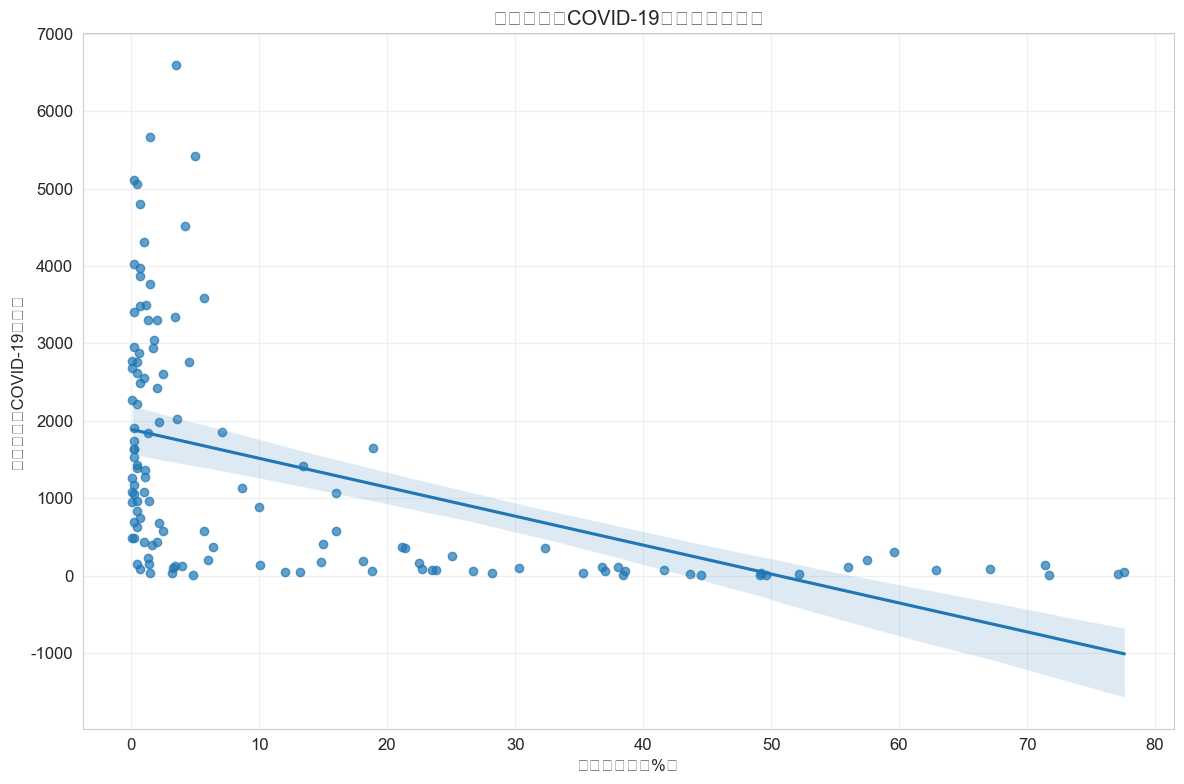

In [17]:
# 计算极端贫困率与死亡率的相关性
corr, p_value = stats.pearsonr(country_poverty['extreme_poverty'], country_poverty['total_deaths_per_million'])
print(f"极端贫困率与COVID-19死亡率的相关系数: {corr:.3f} (p={p_value:.3f})")

# 绘制回归直线
plt.figure(figsize=(12, 8))
sns.regplot(x='extreme_poverty', y='total_deaths_per_million', data=country_poverty, scatter_kws={'alpha':0.7})
plt.xlabel('极端贫困率（%）')
plt.ylabel('每百万人口COVID-19死亡数')
plt.title('极端贫困与COVID-19死亡率的相关性')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [19]:
# 多元回归分析：考虑GDP、极端贫困和严格度对死亡率的影响
# 首先删除包含缺失值的行
country_poverty_clean = country_poverty.dropna(subset=['gdp_per_capita', 'extreme_poverty', 'stringency_index', 'total_deaths_per_million'])

X = country_poverty_clean[['gdp_per_capita', 'extreme_poverty', 'stringency_index']]
X = sm.add_constant(X)  # 添加常数项
y = country_poverty_clean['total_deaths_per_million']

# 拟合模型
model = sm.OLS(y, X).fit()
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     total_deaths_per_million   R-squared:                       0.282
Model:                                  OLS   Adj. R-squared:                  0.262
Method:                       Least Squares   F-statistic:                     14.64
Date:                      Thu, 20 Mar 2025   Prob (F-statistic):           4.15e-08
Time:                              14:30:25   Log-Likelihood:                -993.67
No. Observations:                       116   AIC:                             1995.
Df Residuals:                           112   BIC:                             2006.
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [20]:
# 按收入水平分组分析极端贫困与COVID-19影响
# 将国家按GDP分组
country_poverty['gdp_group'] = pd.qcut(country_poverty['gdp_per_capita'], 3, labels=['低收入', '中等收入', '高收入'])

# 按GDP组和极端贫困程度分析
# 将极端贫困率分成三组：低(<5%)、中(5-20%)、高(>20%)
country_poverty['poverty_group'] = pd.cut(country_poverty['extreme_poverty'], 
                                         bins=[0, 5, 20, 100], 
                                         labels=['低贫困', '中贫困', '高贫困'])

# 计算每个GDP和贫困组合的平均死亡率
poverty_gdp_impact = country_poverty.groupby(['gdp_group', 'poverty_group']).agg({
    'total_deaths_per_million': ['mean', 'count'],
    'stringency_index': 'mean'
}).reset_index()

print("按收入和贫困水平分组的COVID-19死亡率:")
print(poverty_gdp_impact)

按收入和贫困水平分组的COVID-19死亡率:
  gdp_group poverty_group total_deaths_per_million       stringency_index
                                              mean count             mean
0       低收入           低贫困               333.822500     4        42.008468
1       低收入           中贫困               204.603333     9        38.366383
2       低收入           高贫困                97.443793    29        38.100368
3      中等收入           低贫困              1888.348966    29        47.044198
4      中等收入           中贫困              1117.657500     8        51.036801
5      中等收入           高贫困               157.092500     4        46.430449
6       高收入           低贫困              2366.889756    41        42.917470
7       高收入           中贫困              3590.850000     1        44.485806
8       高收入           高贫困                      NaN     0              NaN


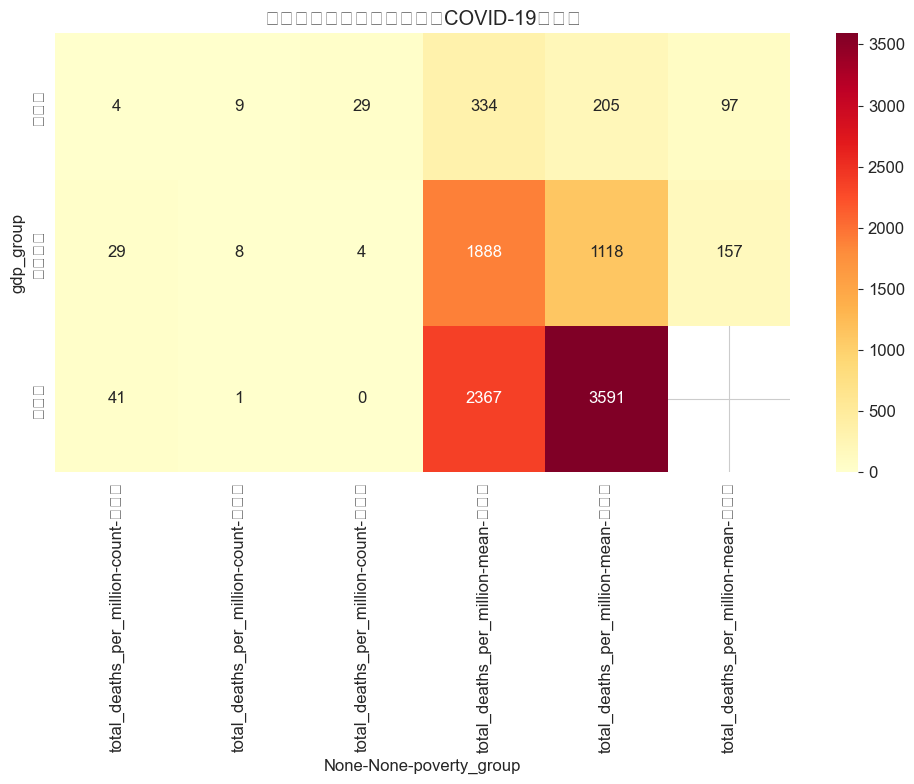

In [22]:
# 绘制热力图：GDP组×贫困组 vs 死亡率
# 将数据重塑为适合热力图的格式
heatmap_data = poverty_gdp_impact.pivot_table(
    index='gdp_group', 
    columns='poverty_group', 
    values=['total_deaths_per_million'],
    aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('不同收入和贫困水平国家的COVID-19死亡率')
plt.tight_layout()

## 6. 结论与发现

通过对 COVID-19 健康和社会经济影响的分析，我们得出以下主要发现：

1. **对预期寿命的影响**：COVID-19 对全球预期寿命造成了显著的负面影响，特别是在南美和欧洲等死亡率较高的地区。根据我们的估算，在受影响最严重的国家，预期寿命可能下降了0.3-0.7年。这一下降幅度虽然看似不大，但在过去几十年中，预期寿命的每一点提高都需要多年的公共卫生努力。
   
2. **健康影响与经济影响的关系**：数据显示，健康影响（死亡率）和经济影响（严格度指数代表的限制措施）之间存在复杂的关系。总体而言，高收入国家在同等严格度下通常能实现更低的死亡率，表明其政策效率更高，这可能得益于更强的医疗系统和更好的社会保障。
   
3. **低收入国家的不成比例影响**：尽管低收入和高极端贫困率的国家在官方统计的 COVID-19 死亡率上不一定更高（可能受到检测和报告能力的限制），但多元回归分析表明，当控制其他因素后，贫困确实与不良健康结果相关。特别是，中等收入但贫困率高的国家往往有最严重的健康结果，表明这些国家可能同时面临医疗系统压力和社会经济弱点的双重挑战。
   
4. **地区差异**：不同地区的影响差异显著。欧洲和南美洲的死亡率普遍较高，而亚洲和大洋洲的表现相对较好。这可能反映了文化因素、社会结构、先前的流行病经验以及应对措施的及时性和适当性等多种因素的影响。

总的来说，这些发现强调了 COVID-19 不仅是一个健康危机，也是一个深刻的社会经济危机，其影响在不同国家和人口群体间分布不均。这一理解对于制定更具包容性和针对性的公共卫生政策，以及为未来可能出现的大流行做准备，具有重要意义。